In [1]:
# http://proceedings.mlr.press/v101/huang19a/huang19a.pdf
# https://www.researchgate.net/publication/220875351_Generative_Models_for_Labeling_Multi-object_Configurations_in_Images
# https://www.tensorflow.org/datasets/catalog/open_images_v4
# Auto-Encoding Progressive Generative Adversarial Networks For 3D Multi Object Scenes

In [2]:
# TODO 
# for data set kitt (as AD case study) - for the built model 
# 1. report model loss for validation dataset - Done
# 2. visualize reconstructed images - Done
# 3. Grid search (K, cov type) for gaussian mixture log p comparison (or baysian parameter optimization) - SKIP
# reason: nead to focus on core idea - GM is good other than G in Autonomous driving on a simplified case
# 4. read about inf Gaussian mixture  https://www.seas.harvard.edu/courses/cs281/papers/rasmussen-1999a.pdf

In [3]:
%config Completer.use_jedi = False
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import logging
import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.mixture import GaussianMixture
import os

seed = 1
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
batch_size = 32
epochs = 10
dataset_name = 'kitti'

In [5]:
train_ds,test_ds,validation_ds = tfds.load(name=dataset_name,split=['train', 'test','validation']\
                                           ,as_supervised=False,download=False)

In [6]:
dims = [x['image'].get_shape().as_list() for x in train_ds]
dims_df= pd.DataFrame.from_records(data=dims,columns=['height','width','depth'])
dims_df.describe()

,height,width,depth
count,6347.000000,6347.000000,6347.0
mean,374.481960,1240.112494,3.0
std,1.447946,5.220926,0.0
min,370.000000,1224.000000,3.0
25%,375.000000,1242.000000,3.0
50%,375.000000,1242.000000,3.0
75%,375.000000,1242.000000,3.0
max,375.000000,1242.000000,3.0


In [7]:
height = 2**(int(np.log2(min(dims_df['height']))))
width = 2**(int(np.log2(min(dims_df['width']))))
height,width = min(height,width),min(height,width)
height,width

(256, 256)

In [8]:
train_ds = train_ds.map(lambda x: tf.image.resize(images=tf.cast(x['image'],dtype=tf.float32)/255.,\
                                                  size=[height,width]))
train_ds = train_ds.batch(batch_size,drop_remainder=True)
train_ds_double_zipped = tf.data.Dataset.zip(datasets=(train_ds,train_ds))

###
test_ds = test_ds.map(lambda x: tf.image.resize(tf.cast(x['image'],dtype=tf.float32)/255.,\
                                                size=[height,width]))
test_ds = test_ds.batch(batch_size,drop_remainder=True)
test_ds_double_zipped = tf.data.Dataset.zip(datasets=(test_ds,test_ds))

###
validation_ds = validation_ds.map(lambda x: tf.image.resize(tf.cast(x['image'],dtype=tf.float32)/255.\
                                                            ,size=[height,width]))
validation_ds = validation_ds.batch(batch_size,drop_remainder=True)
validation_ds_double_zipped = tf.data.Dataset.zip(datasets=(validation_ds,validation_ds))


In [9]:
# just to detect the dimension distribution
# dims = [x.get_shape().as_list() for x in train_ds]
# dims_df= pd.DataFrame.from_records(data=dims,columns=['batch','height','width','depth'])
# dims_df.describe()

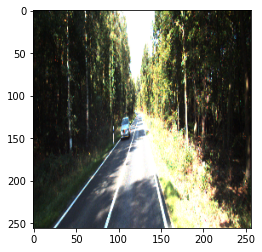

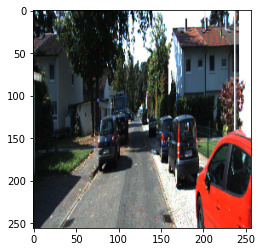

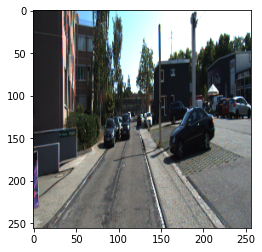

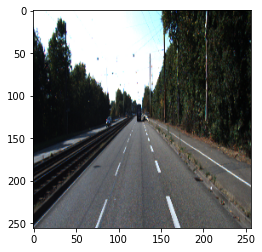

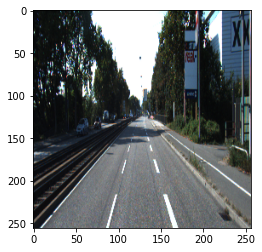

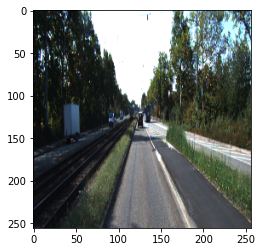

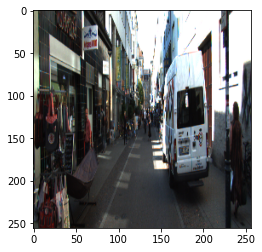

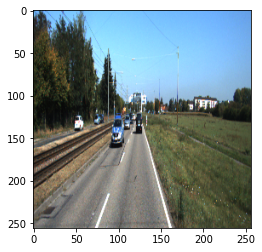

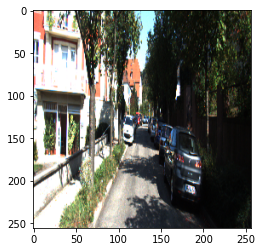

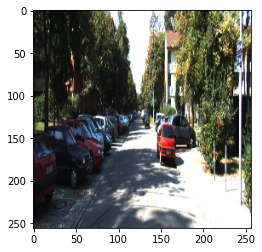

In [10]:
for e in train_ds.take(10):
    plt.imshow(e[0].numpy())
    plt.show()

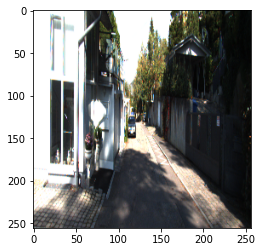

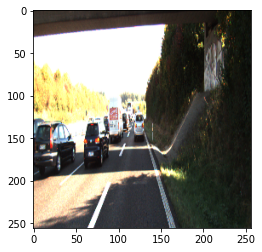

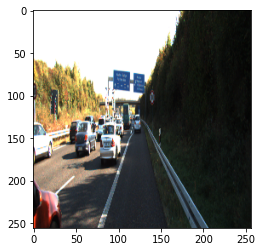

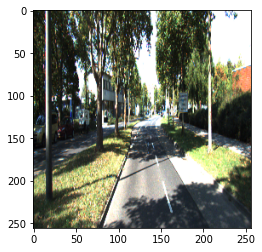

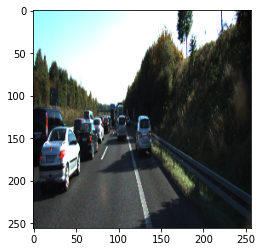

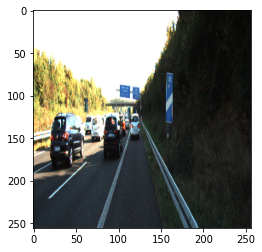

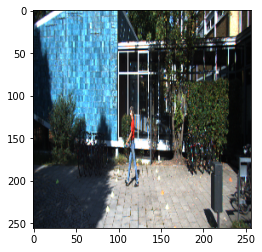

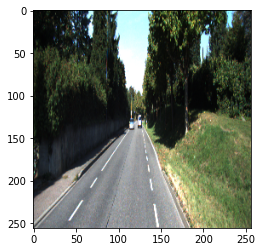

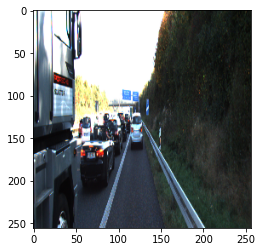

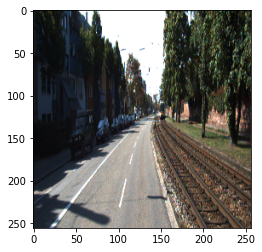

In [11]:
for e in test_ds.take(10):
    plt.imshow(e[0].numpy())
    plt.show()

In [12]:
latent_dim = 64
batch_size = 32
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CAE')
        self.encoder = tf.keras.Sequential(name='encoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(height, width, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(name='decoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=int(height/4) * int(width/4) * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(int(height/4), int(width/4), 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

        self.encoder.summary()
        self.decoder.summary()
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cae = CAE(latent_dim)
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 254016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                16257088  
Total params: 16,276,480
Trainable params: 16,276,480
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 131072)            8519680   
______________________________

In [13]:
model_file_path = f'./models/cae_dataset_{dataset_name}_z_dim_{latent_dim}'
print(f'model path = {model_file_path}')

model path = ./models/cae_dataset_kitti_z_dim_64


In [14]:
if os.path.exists(model_file_path):
    print('loading saved model')
    cae = tf.keras.models.load_model(filepath=model_file_path)
else:
    print('building model')
    # use checkpoints to save model fitting progress
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_filepath = './checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='max',
        save_best_only=True)
    # Model weights are saved at the end of every epoch, if it's the best seen
    # so far.
    cae.fit(x=train_ds_double_zipped,validation_data=test_ds_double_zipped,epochs=epochs,\
            callbacks=[model_checkpoint_callback])
    # The model weights (that are considered the best) are loaded into the model.
    cae.load_weights(checkpoint_filepath)
    print('saving model')
    cae.save(filepath=model_file_path)

building model
Epoch 1/10
198/198 [==============================] - 224s 1s/step - loss: 0.0880 - val_loss: 0.0370
Epoch 2/10
198/198 [==============================] - 215s 1s/step - loss: 0.0391 - val_loss: 0.0319
Epoch 3/10
198/198 [==============================] - 213s 1s/step - loss: 0.0332 - val_loss: 0.0309
Epoch 4/10
198/198 [==============================] - 1228s 6s/step - loss: 0.0304 - val_loss: 0.0293
Epoch 5/10
198/198 [==============================] - 215s 1s/step - loss: 0.0284 - val_loss: 0.0287
Epoch 6/10
198/198 [==============================] - 217s 1s/step - loss: 0.0271 - val_loss: 0.0292
Epoch 7/10
198/198 [==============================] - 1840s 9s/step - loss: 0.0263 - val_loss: 0.0290
Epoch 8/10
198/198 [==============================] - 227s 1s/step - loss: 0.0259 - val_loss: 0.0297
Epoch 9/10
198/198 [==============================] - 246s 1s/step - loss: 0.0257 - val_loss: 0.0305
Epoch 10/10
198/198 [==============================] - 219s 1s/step - loss

INFO:tensorflow:Assets written to: ./models/cae_dataset_kitti_z_dim_64/assets


In [15]:
# create valdation dataset tensor
initial_state = tf.zeros(dtype=tf.float32,shape=e.shape)
validation_ds_tensor = validation_ds.\
        reduce(initial_state=initial_state,reduce_func=lambda x,y: tf.concat(values=[x,y],axis=0))
validation_ds_tensor = validation_ds_tensor[batch_size:] # drop dummy initial state

In [16]:
# calculate loss, can be compare over different dataset due to data scaling from 0 to 1
y_predicted = cae.predict(validation_ds)
cae_loss = cae.loss(y_pred=y_predicted,y_true=validation_ds_tensor).numpy()
print(f'CAE loss for dataset {dataset_name} = {np.round(cae_loss,4)}')

CAE loss for dataset kitti = 0.047200001776218414


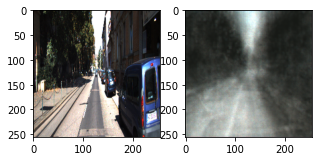

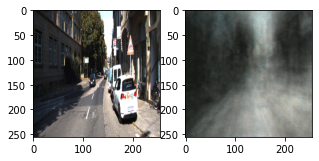

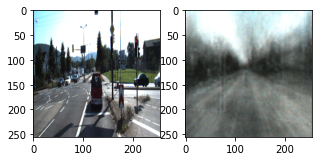

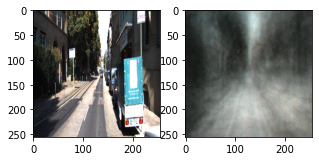

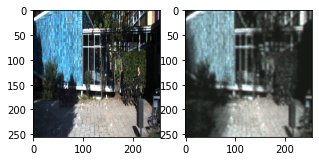

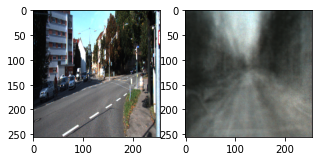

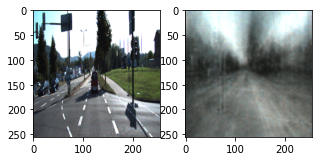

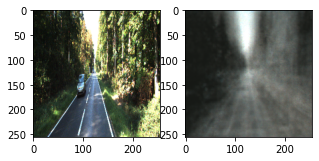

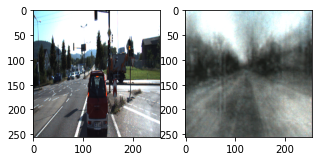

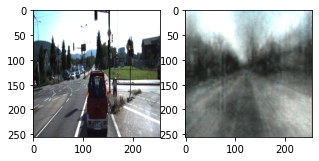

In [18]:
# plot decoded images
test_sample = None
for batch in validation_ds.take(1):
        test_sample = batch
        z = cae.encoder(test_sample).numpy()
        decoded_imgs = cae.decoder(z).numpy()
        decoded_imgs = tf.maximum(decoded_imgs,0)
        decoded_imgs = tf.minimum(decoded_imgs,1)
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(5,5,forward=True)
    ax1.imshow(test_sample[i])
    ax2.imshow(decoded_imgs[i])
    # display original
#     ax = plt.subplot(1)
#     plt.imshow(test_sample[i])
#     plt.title("original")
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # display reconstruction
#     ax = plt.subplot(2)
#     plt.imshow(decoded_imgs[i])
#     plt.title("reconstructed")
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
# getting z tensor
z_tensor = None

inf_or_unknown_cardinality = ((test_ds.cardinality()==tf.data.INFINITE_CARDINALITY)\
    or (test_ds.cardinality() == tf.data.UNKNOWN_CARDINALITY)).numpy()
batches = test_ds.cardinality().numpy() if not inf_or_unknown_cardinality else 500

with tqdm(total=batches) as pbar:
    for batch in test_ds.take(batches):
        z = cae.encoder(batch).numpy()
        if z_tensor is None:
            z_tensor = tf.convert_to_tensor(z)
        else:
            z_tensor = tf.concat([z_tensor,tf.convert_to_tensor(z)],axis=0)
        pbar.update(1)
        #print(f'z shape {z.shape}')
#         decoded_imgs = cae.decoder(z).numpy()
#         #print(f'decoded images shape {decoded_imgs[0].shape}')
#         plt.imshow(batch[0])
#         plt.show()
#         plt.imshow(decoded_imgs[0])
#         plt.show()
z_tensor.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/22 [00:00<?, ?it/s]

TensorShape([704, 64])

In [20]:
z_np= z_tensor.numpy()
n_z = z_np.shape[0]
n_z_train = int(0.8*n_z)
z_train = z_np[:n_z_train]
z_test = z_np[n_z_train:]

In [24]:

random_state = 1
reg_covar = 0.1
cov_type = 'diag'

print(f"""For Dateset "{dataset_name}" Calculating relative difference of log likelihood  """)
print(f'Latent_dim = {latent_dim}, Gaussiam Mixture covariance type = {cov_type} and reg_covar = {reg_covar}   ')
print('############################  ')


g_fit = GaussianMixture(n_components=1,covariance_type=cov_type,random_state=1,reg_covar=reg_covar).fit(z_train)
logp_g = g_fit.score(X=z_test)
for k in [10,20,50,70,80,100,200]:
    try:
        gm_fit = GaussianMixture(n_components=k,covariance_type=cov_type,random_state=random_state,\
                                 reg_covar=reg_covar).fit(z_train)
        logp_gm = gm_fit.score(X=z_test)

        rel_diff_logps = (logp_gm- logp_g) / np.abs(logp_g)
        print(f'logp Gaussin Mixture with k = {k} = {logp_gm}  ')
        print(f'logp Gaussian Diagonal = {logp_g}  ')
        print(f'At k = {k} , rel_diff for logps = {rel_diff_logps}  ')
        print('##############  ')
    except Exception as e:
        print(f'Catched expection {e}  ')

For Dateset "kitti" Calculating relative difference of log likelihood  
Latent_dim = 64, Gaussiam Mixture covariance type = diag and reg_covar = 0.1   
############################  
logp Gaussin Mixture with k = 10 = -75.45441572317257  
logp Gaussian Diagonal = -115.44620189247304  
At k = 10 , rel_diff for logps = 0.346410583576833  
##############  
logp Gaussin Mixture with k = 20 = -69.64451526564827  
logp Gaussian Diagonal = -115.44620189247304  
At k = 20 , rel_diff for logps = 0.39673619292806717  
##############  
logp Gaussin Mixture with k = 50 = -55.93752814502553  
logp Gaussian Diagonal = -115.44620189247304  
At k = 50 , rel_diff for logps = 0.5154667089253753  
##############  
logp Gaussin Mixture with k = 70 = -50.88304211844375  
logp Gaussian Diagonal = -115.44620189247304  
At k = 70 , rel_diff for logps = 0.559248885763809  
##############  
logp Gaussin Mixture with k = 80 = -52.1276428852566  
logp Gaussian Diagonal = -115.44620189247304  
At k = 80 , rel_diff

## Results

**For Dateset "kitti" Calculating relative difference of log likelihood**  
Latent_dim = 64, Gaussiam Mixture covariance type = diag and reg_covar = 0.1   
############################  
logp Gaussin Mixture with k = 10 = -75.45441572317257  
logp Gaussian Diagonal = -115.44620189247304  
At k = 10 , rel_diff for logps = 0.346410583576833  
##############  
logp Gaussin Mixture with k = 20 = -69.64451526564827  
logp Gaussian Diagonal = -115.44620189247304  
At k = 20 , rel_diff for logps = 0.39673619292806717  
##############  
logp Gaussin Mixture with k = 50 = -55.93752814502553  
logp Gaussian Diagonal = -115.44620189247304  
At k = 50 , rel_diff for logps = 0.5154667089253753  
##############  
logp Gaussin Mixture with k = 70 = -50.88304211844375  
logp Gaussian Diagonal = -115.44620189247304  
At k = 70 , rel_diff for logps = 0.559248885763809  
##############  
logp Gaussin Mixture with k = 80 = -52.1276428852566  
logp Gaussian Diagonal = -115.44620189247304  
At k = 80 , rel_diff for logps = 0.5484681000262923  
##############  
logp Gaussin Mixture with k = 100 = -54.52694195135895  
logp Gaussian Diagonal = -115.44620189247304  
At k = 100 , rel_diff for logps = 0.5276852676180243  
##############  
logp Gaussin Mixture with k = 200 = -68.2897651271402  
logp Gaussian Diagonal = -115.44620189247304  
At k = 200 , rel_diff for logps = 0.40847109729304476  
##############  

**For Dateset VOC Calculating relative difference of log likelihood**  
############################  
logp Gaussin Mixture with k = 10 = 3239.302399019124  
logp Gaussian Diagonal = 2790.16976645871  
At k = 10 , rel_diff for logps = 0.16096964348174925  
##############  
logp Gaussin Mixture with k = 20 = 3334.117578802105  
logp Gaussian Diagonal = 2790.16976645871  
At k = 20 , rel_diff for logps = 0.19495151115259016  
##############  
logp Gaussin Mixture with k = 50 = 3411.8171131494596  
logp Gaussian Diagonal = 2790.16976645871  
At k = 50 , rel_diff for logps = 0.22279911214138984  
##############  
logp Gaussin Mixture with k = 70 = 3429.9682203595194  
logp Gaussian Diagonal = 2790.16976645871  
At k = 70 , rel_diff for logps = 0.22930448949450236  
##############  
logp Gaussin Mixture with k = 100 = 3428.6442835155385  
logp Gaussian Diagonal = 2790.16976645871  
At k = 100 , rel_diff for logps = 0.22882998903223795  
##############  
logp Gaussin Mixture with k = 200 = 3415.867706729245  
logp Gaussian Diagonal = 2790.16976645871  
At k = 200 , rel_diff for logps = 0.22425084946163418  
##############  

**For Dateset wider_face Calculating relative difference of log likelihood**    
############################  
logp Gaussin Mixture with k = 10 = 1726.1243177708377  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 10 , rel_diff for logps = 0.10515382744194393  
##############  
logp Gaussin Mixture with k = 20 = 1751.7959812169918  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 20 , rel_diff for logps = 0.1215901506095347  
##############  
logp Gaussin Mixture with k = 50 = 1776.35932923814  
logp Gaussian Diagonal = 1561.8860242887904  
At k = 50 , rel_diff for logps = 0.13731687307145898  
##############  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  
Catched expection Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.  



**For Dateset "mnist" Calculating relative difference of log likelihood**  
############################  
logp Gaussin Mixture with k = 10 = 7841.956234385311  
logp Gaussian Diagonal = 7377.442821602376  
At k = 10 , rel_diff for logps = 0.06296401395653828  
##############  
logp Gaussin Mixture with k = 20 = 7988.197403977028  
logp Gaussian Diagonal = 7377.442821602376  
At k = 20 , rel_diff for logps = 0.08278675919876485  
##############  
logp Gaussin Mixture with k = 50 = 8243.583374395243  
logp Gaussian Diagonal = 7377.442821602376  
At k = 50 , rel_diff for logps = 0.11740389912025657  
##############  
logp Gaussin Mixture with k = 70 = 8305.125097353703  
logp Gaussian Diagonal = 7377.442821602376  
At k = 70 , rel_diff for logps = 0.12574577644098017  
##############  
logp Gaussin Mixture with k = 100 = 8385.913961674707  
logp Gaussian Diagonal = 7377.442821602376  
At k = 100 , rel_diff for logps = 0.1366965714894272  
##############  
logp Gaussin Mixture with k = 200 = 8500.999476912375  
logp Gaussian Diagonal = 7377.442821602376  
At k = 200 , rel_diff for logps = 0.15229622004253812  
##############  

**For Dateset "cifar100" Calculating relative difference of log likelihood**
############################  
logp Gaussin Mixture with k = 10 = 4348.738804362613  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 10 , rel_diff for logps = 0.07647131016925454  
##############  
logp Gaussin Mixture with k = 20 = 4384.332721210587  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 20 , rel_diff for logps = 0.08528210153362795  
##############  
logp Gaussin Mixture with k = 50 = 4422.78147918955  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 50 , rel_diff for logps = 0.09479957010048548  
##############  
logp Gaussin Mixture with k = 70 = 4428.119142994677  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 70 , rel_diff for logps = 0.09612083638205283  
##############  
logp Gaussin Mixture with k = 100 = 4425.925444793071  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 100 , rel_diff for logps = 0.09557781614482229  
##############  
logp Gaussin Mixture with k = 200 = 4424.68448280697  
logp Gaussian Diagonal = 4039.8092947584987  
At k = 200 , rel_diff for logps = 0.09527063283601832  
##############  

**For Dateset "kitti" Calculating relative difference of log likelihood**  
############################  
logp Gaussin Mixture with k = 10 = -34.24735184191114  
logp Gaussian Diagonal = -41.930338780990496  
At k = 10 , rel_diff for logps = 0.18323216941339165  
##############  
logp Gaussin Mixture with k = 20 = -34.24435458548877  
logp Gaussian Diagonal = -41.930338780990496  
At k = 20 , rel_diff for logps = 0.1833036512213022  
##############  
logp Gaussin Mixture with k = 50 = -46.61571345046477  
logp Gaussian Diagonal = -41.930338780990496  
At k = 50 , rel_diff for logps = -0.11174187487362798  
##############  
logp Gaussin Mixture with k = 70 = -60.034207750969685  
logp Gaussian Diagonal = -41.930338780990496  
At k = 70 , rel_diff for logps = -0.4317606176410562  
##############  
logp Gaussin Mixture with k = 80 = -68.72428906022188  
logp Gaussian Diagonal = -41.930338780990496  
At k = 80 , rel_diff for logps = -0.6390110611598174  
##############  
logp Gaussin Mixture with k = 100 = -79.52021662158452  
logp Gaussian Diagonal = -41.930338780990496  
At k = 100 , rel_diff for logps = -0.8964840002112204  
##############  
logp Gaussin Mixture with k = 200 = -130.67638439289198  
logp Gaussian Diagonal = -41.930338780990496  
At k = 200 , rel_diff for logps = -2.11651153298421  
##############  